In [153]:
runfile('C:/Users/we609/Desktop/cs 4762/project/3K_brain/data_preprocess.py', wdir='C:/Users/we609/Desktop/cs 4762/project/3K_brain')

In [ ]:
import numpy as np # numpy for making arrays and doing math on them
import pandas as pd # pandas for importing spreadsheet data and manipulating it
import scipy as sp # scipy for solving equations
import matplotlib as mpl # matplotlib for graphing
import matplotlib.pyplot as plt # the pyplot functions from mathplotlib as plt
import math # math for things like constants (e or pi) and some simple math
import random
import seaborn as sns
import matplotlib
import matplotlib.pylab as pylab
from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
from matplotlib_venn import venn3, venn3_circles
params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
pylab.rcParams.update(params)
import matplotlib.ticker as mticker  
#set the style
sns.set_style("whitegrid")

In [36]:
peak = pd.read_csv('normalize_peak.csv')
expression = pd.read_csv('normalize_expression_level.csv')

In [38]:
X_train, X_val, X_test, y_train, y_val, y_test = sample_split(expression,peak, 3233)

[pca] >Processing dataframe..
[pca] >The PCA reduction is performed on the [2587] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[5]
[pca] >Outlier detection using SPE/DmodX with n_std=[2]


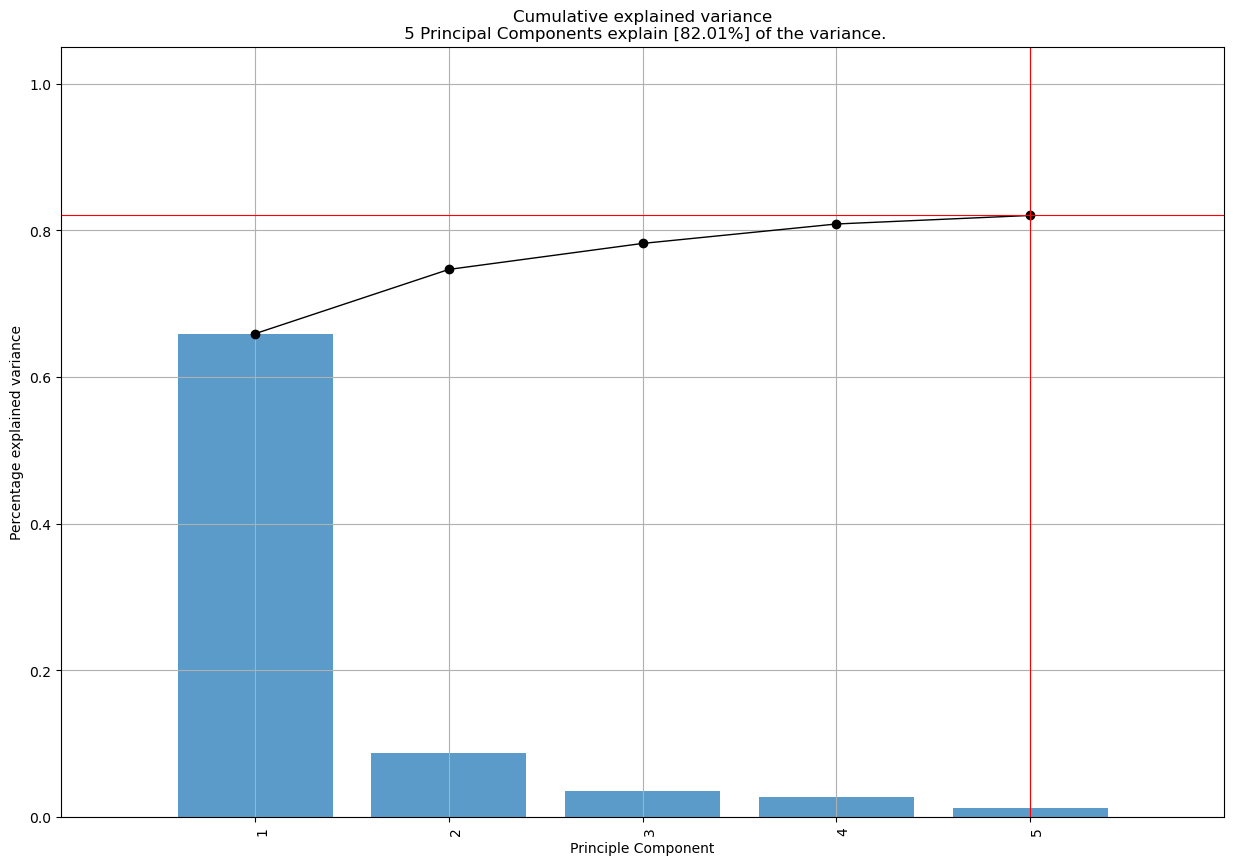

<Figure size 640x480 with 0 Axes>

In [39]:
X_train_smoothed = aggregate_smooth_function(y_train, X_train, components = 5,k= 30, fig_name = 'PCA_result.png')

In [31]:
#X_train, X_val, X_test, y_train, y_val, y_test

In [67]:
#calculation ridge for smoothed X_train 
R_2_smooth_ridge = []
possibility_smooth_ridge = []
All_beta_smooth_ridge = []
RMSE_values_smooth_ridge = []
for index, gene in expression.iterrows():
    if 'chr' not in str(gene['chromosome']):
        continue
    current_chr = gene['chromosome']
    feature_id = gene['feature_id']
    
    X_train_i, y_train_i, distant = gene_extraction(feature_id,current_chr, y_train, X_train_smoothed,5000000)
    X_val_i, y_val_i, _  = gene_extraction(feature_id,current_chr, y_val, X_val,5000000)
    X_test_i, y_test_i, _ = gene_extraction(feature_id,current_chr, y_test, X_test,5000000)
    
    if len(X_train_i)== 0:
        continue
    
    beta = ridge_regression_optimaization(X_train_i, y_train_i,X_val_i, y_val_i, distants = distant, iterations = 200, learning_rate = 0.02)
    
    if beta != None and len(beta) != 0 and torch.isnan(beta)[0] != True:#eliminate some bad results
        
        pred_test = X_test_i @ beta # make predictions on the test set
        R,p = scipy.stats.pearsonr(y_test_i, pred_test)
        R_2_smooth_ridge += [R**2]
        possibility_smooth_ridge += [p]
        All_beta_smooth_ridge += [beta]
    

        MSE = mean_squared_error(y_test_i, pred_test)
        RMSE = math.sqrt(MSE)
        RMSE_values_smooth_ridge += [RMSE]


In [75]:
#calculation lasso for smoothed X_train
R_2_smooth_lasso = []
possibility_smooth_lasso = []
All_beta_smooth_lasso = []
RMSE_values_smooth_lasso = []
for index, gene in expression.iterrows():
    if 'chr' not in str(gene['chromosome']):
        continue
    current_chr = gene['chromosome']
    feature_id = gene['feature_id']
    
    X_train_i, y_train_i, distant = gene_extraction(feature_id,current_chr, y_train, X_train_smoothed,5000000)
    X_val_i, y_val_i, _  = gene_extraction(feature_id,current_chr, y_val, X_val,5000000)
    X_test_i, y_test_i, _ = gene_extraction(feature_id,current_chr, y_test, X_test,5000000)
    
    if len(X_train_i)== 0:
        continue
    
    beta = lasso_regression_optimaization(X_train_i, y_train_i,X_val_i, y_val_i, distants = distant, iterations = 200, learning_rate = 0.02)
    
    if beta != None and len(beta) != 0 and torch.isnan(beta)[0] != True:#eliminate some bad results
        
        pred_test = X_test_i @ beta # make predictions on the test set
        R,p = scipy.stats.pearsonr(y_test_i, pred_test)
        R_2_smooth_lasso += [R**2]
        possibility_smooth_lasso += [p]
        All_beta_smooth_lasso += [beta]
    

        MSE = mean_squared_error(y_test_i, pred_test)
        RMSE = math.sqrt(MSE)
        RMSE_values_smooth_lasso += [RMSE]



In [77]:
#calculation ridge for X_train
R_2_ridge = []
possibility_ridge = []
All_beta_ridge = []
RMSE_values_ridge = []
for index, gene in expression.iterrows():
    if 'chr' not in str(gene['chromosome']):
        continue
    current_chr = gene['chromosome']
    feature_id = gene['feature_id']
    
    X_train_i, y_train_i, distant = gene_extraction(feature_id,current_chr, y_train, X_train,5000000)
    X_val_i, y_val_i, _  = gene_extraction(feature_id,current_chr, y_val, X_val,5000000)
    X_test_i, y_test_i, _ = gene_extraction(feature_id,current_chr, y_test, X_test,5000000)
    
    if len(X_train_i)== 0:
        continue
    
    beta = ridge_regression_optimaization(X_train_i, y_train_i,X_val_i, y_val_i, distants = distant, iterations = 200, learning_rate = 0.02)
    
    if beta != None and len(beta) != 0 and torch.isnan(beta)[0] != True:#eliminate some bad results
        
        pred_test = X_test_i @ beta # make predictions on the test set
        R,p = scipy.stats.pearsonr(y_test_i, pred_test)
        R_2_ridge += [R**2]
        possibility_ridge += [p]
        All_beta_ridge += [beta]
    

        MSE = mean_squared_error(y_test_i, pred_test)
        RMSE = math.sqrt(MSE)
        RMSE_values_ridge += [RMSE]

In [148]:
#calculation lasso for X_train
R_2_lasso = []
possibility_lasso = []
All_beta_lasso = []
RMSE_values_lasso = []
for index, gene in expression.iterrows():
    if 'chr' not in str(gene['chromosome']):
        continue
    current_chr = gene['chromosome']
    feature_id = gene['feature_id']
    
    X_train_i, y_train_i, distant = gene_extraction(feature_id,current_chr, y_train, X_train,5000000)
    X_val_i, y_val_i, _  = gene_extraction(feature_id,current_chr, y_val, X_val,5000000)
    X_test_i, y_test_i, _ = gene_extraction(feature_id,current_chr, y_test, X_test,5000000)
    
    if len(X_train_i)== 0:
        continue
    
    beta = lasso_regression_optimaization(X_train_i, y_train_i,X_val_i, y_val_i, distants = distant, iterations = 200, learning_rate = 0.02)
    
    if beta != None and len(beta) != 0 and torch.isnan(beta)[0] != True:#eliminate some bad results
        
        pred_test = X_test_i @ beta # make predictions on the test set
        R,p = scipy.stats.pearsonr(y_test_i, pred_test)
        R_2_lasso += [R**2]
        possibility_lasso += [p]
        All_beta_lasso += [beta]
    

        MSE = mean_squared_error(y_test_i, pred_test)
        RMSE = math.sqrt(MSE)
        RMSE_values_lasso += [RMSE]


In [149]:
temp_df_rows = []
for i in R_2_lasso:
    temp_df_rows += [['Lasso', i]]
for i in R_2_ridge:
    temp_df_rows += [['Ridge', i]]
for i in R_2_smooth_ridge:
    temp_df_rows += [['Ridge_K-nearest_smooth', i]]
for i in R_2_smooth_lasso:
    temp_df_rows += [['lasso_K-nearest_smooth', i]]

temp_df = pd.DataFrame(temp_df_rows, columns=['Models', 'R^2'])

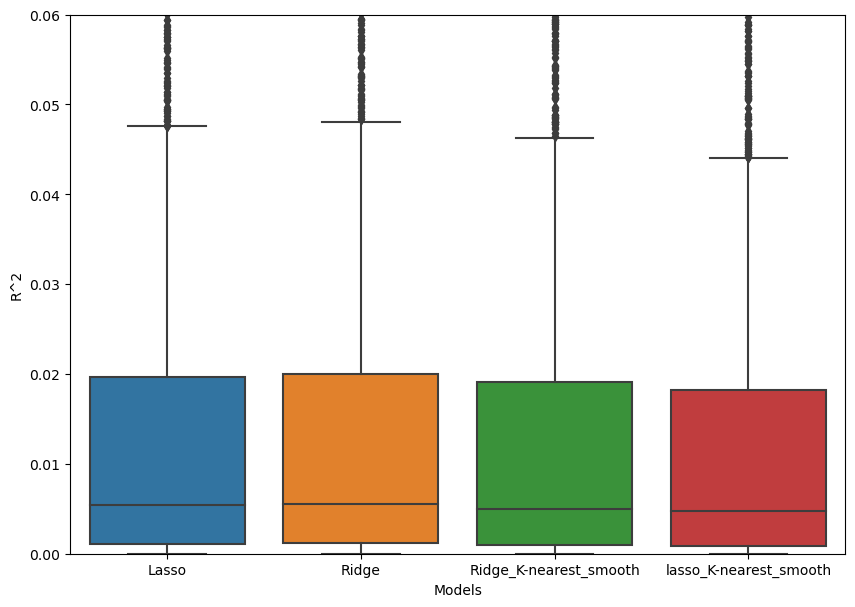

In [174]:


figures = plt.figure(figsize = (10,7))

#plot = sns.stripplot(x="Models", y='R^2', data=temp_df, size = 10, color = 'blue', alpha = 0.3)

#Hybrid_First = [mean_pluri, mean_meso, mean_cardio]
#error = [std_pluri, std_meso, std_pluri]
#plt.errorbar(range(3), Hybrid_First, yerr=error, capsize = 8, ecolor = 'grey', ls = 'none')
ax = sns.boxplot(x="Models", y="R^2", data=temp_df)

ax.set(ylim=(0,0.06))

x_pos = np.arange(len(conditions))
plt.savefig("Z_score Normalization")


The second normalization method:




In [155]:
peak_log = pd.read_csv('log_read_depth_normalized_peak.csv')
expression_log = pd.read_csv('log_read_depth_normalized_expression_level.csv')

In [160]:
X_train, X_val, X_test, y_train, y_val, y_test = sample_split(expression_log,peak_log, 3233)

[pca] >Processing dataframe..
[pca] >The PCA reduction is performed on the [2587] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[5]
[pca] >Outlier detection using SPE/DmodX with n_std=[2]


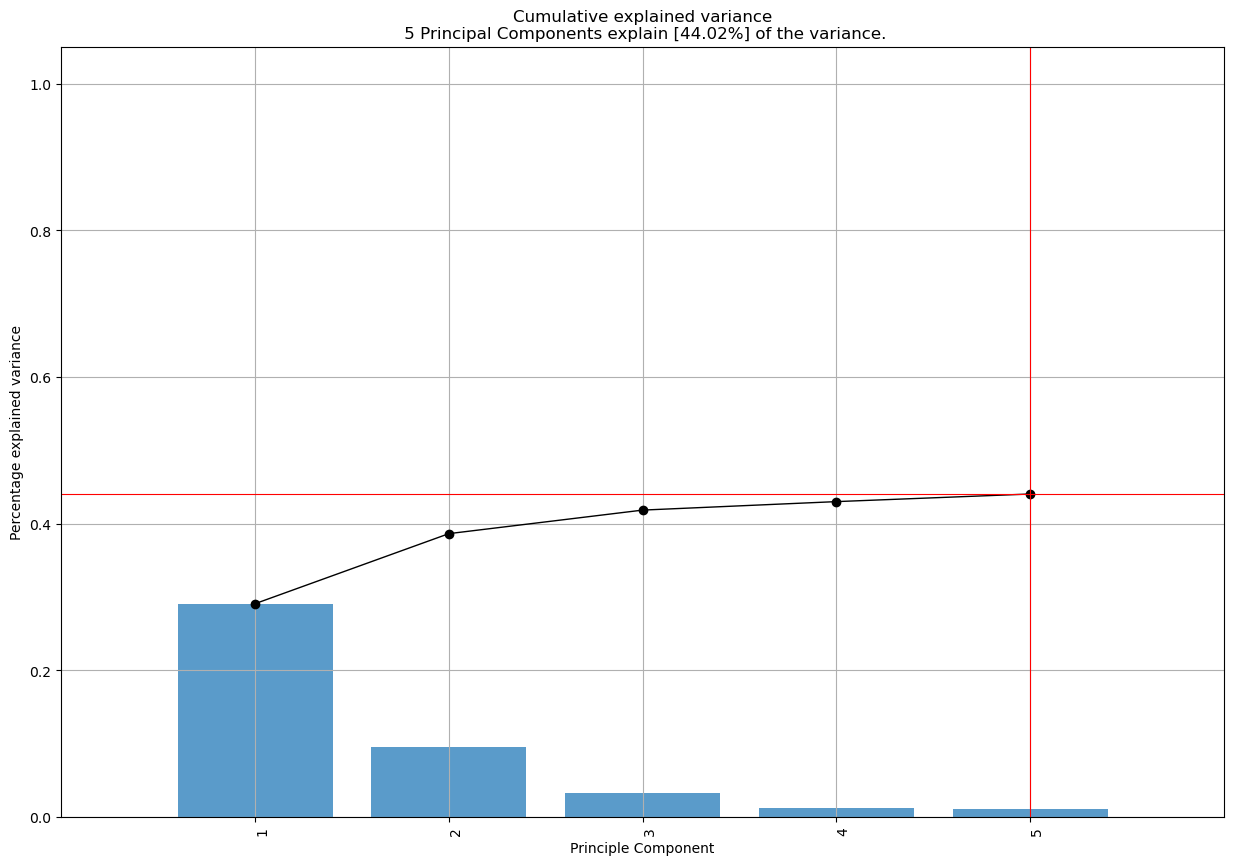

<Figure size 640x480 with 0 Axes>

In [161]:
X_train_smoothed = aggregate_smooth_function(y_train, X_train, components = 5,k= 30, fig_name = 'PCA_result_2.png')

In [162]:
#calculation ridge for smoothed X_train 
R_2_smooth_ridge = []
possibility_smooth_ridge = []
All_beta_smooth_ridge = []
RMSE_values_smooth_ridge = []
for index, gene in expression.iterrows():
    if 'chr' not in str(gene['chromosome']):
        continue
    current_chr = gene['chromosome']
    feature_id = gene['feature_id']
    
    X_train_i, y_train_i, distant = gene_extraction(feature_id,current_chr, y_train, X_train_smoothed,5000000)
    X_val_i, y_val_i, _  = gene_extraction(feature_id,current_chr, y_val, X_val,5000000)
    X_test_i, y_test_i, _ = gene_extraction(feature_id,current_chr, y_test, X_test,5000000)
    
    if len(X_train_i)== 0:
        continue
    
    beta = ridge_regression_optimaization(X_train_i, y_train_i,X_val_i, y_val_i, distants = distant, iterations = 200, learning_rate = 0.02)
    
    if beta != None and len(beta) != 0 and torch.isnan(beta)[0] != True:#eliminate some bad results
        
        pred_test = X_test_i @ beta # make predictions on the test set
        R,p = scipy.stats.pearsonr(y_test_i, pred_test)
        R_2_smooth_ridge += [R**2]
        possibility_smooth_ridge += [p]
        All_beta_smooth_ridge += [beta]
    

        MSE = mean_squared_error(y_test_i, pred_test)
        RMSE = math.sqrt(MSE)
        RMSE_values_smooth_ridge += [RMSE]

In [170]:
sum(R_2_ridge )/len(R_2_ridge )

0.028869511012125846

In [165]:
#calculation lasso for smoothed X_train
R_2_smooth_lasso = []
possibility_smooth_lasso = []
All_beta_smooth_lasso = []
RMSE_values_smooth_lasso = []
for index, gene in expression.iterrows():
    if 'chr' not in str(gene['chromosome']):
        continue
    current_chr = gene['chromosome']
    feature_id = gene['feature_id']
    
    X_train_i, y_train_i, distant = gene_extraction(feature_id,current_chr, y_train, X_train_smoothed,5000000)
    X_val_i, y_val_i, _  = gene_extraction(feature_id,current_chr, y_val, X_val,5000000)
    X_test_i, y_test_i, _ = gene_extraction(feature_id,current_chr, y_test, X_test,5000000)
    
    if len(X_train_i)== 0:
        continue
    
    beta = lasso_regression_optimaization(X_train_i, y_train_i,X_val_i, y_val_i, distants = distant, iterations = 200, learning_rate = 0.02)
    
    if beta != None and len(beta) != 0 and torch.isnan(beta)[0] != True:#eliminate some bad results
        
        pred_test = X_test_i @ beta # make predictions on the test set
        R,p = scipy.stats.pearsonr(y_test_i, pred_test)
        R_2_smooth_lasso += [R**2]
        possibility_smooth_lasso += [p]
        All_beta_smooth_lasso += [beta]
    

        MSE = mean_squared_error(y_test_i, pred_test)
        RMSE = math.sqrt(MSE)
        RMSE_values_smooth_lasso += [RMSE]



In [167]:
#calculation ridge for X_train
R_2_ridge = []
possibility_ridge = []
All_beta_ridge = []
RMSE_values_ridge = []
for index, gene in expression.iterrows():
    if 'chr' not in str(gene['chromosome']):
        continue
    current_chr = gene['chromosome']
    feature_id = gene['feature_id']
    
    X_train_i, y_train_i, distant = gene_extraction(feature_id,current_chr, y_train, X_train,5000000)
    X_val_i, y_val_i, _  = gene_extraction(feature_id,current_chr, y_val, X_val,5000000)
    X_test_i, y_test_i, _ = gene_extraction(feature_id,current_chr, y_test, X_test,5000000)
    
    if len(X_train_i)== 0:
        continue
    
    beta = ridge_regression_optimaization(X_train_i, y_train_i,X_val_i, y_val_i, distants = distant, iterations = 200, learning_rate = 0.02)
    
    if beta != None and len(beta) != 0 and torch.isnan(beta)[0] != True:#eliminate some bad results
        
        pred_test = X_test_i @ beta # make predictions on the test set
        R,p = scipy.stats.pearsonr(y_test_i, pred_test)
        R_2_ridge += [R**2]
        possibility_ridge += [p]
        All_beta_ridge += [beta]
    

        MSE = mean_squared_error(y_test_i, pred_test)
        RMSE = math.sqrt(MSE)
        RMSE_values_ridge += [RMSE]

In [175]:
#calculation lasso for X_train
R_2_lasso = []
possibility_lasso = []
All_beta_lasso = []
RMSE_values_lasso = []
for index, gene in expression.iterrows():
    if 'chr' not in str(gene['chromosome']):
        continue
    current_chr = gene['chromosome']
    feature_id = gene['feature_id']
    
    X_train_i, y_train_i, distant = gene_extraction(feature_id,current_chr, y_train, X_train,5000000)
    X_val_i, y_val_i, _  = gene_extraction(feature_id,current_chr, y_val, X_val,5000000)
    X_test_i, y_test_i, _ = gene_extraction(feature_id,current_chr, y_test, X_test,5000000)
    
    if len(X_train_i)== 0:
        continue
    
    beta = lasso_regression_optimaization(X_train_i, y_train_i,X_val_i, y_val_i, distants = distant, iterations = 200, learning_rate = 0.02)
    
    if beta != None and len(beta) != 0 and torch.isnan(beta)[0] != True:#eliminate some bad results
        
        pred_test = X_test_i @ beta # make predictions on the test set
        R,p = scipy.stats.pearsonr(y_test_i, pred_test)
        R_2_lasso += [R**2]
        possibility_lasso += [p]
        All_beta_lasso += [beta]
    

        MSE = mean_squared_error(y_test_i, pred_test)
        RMSE = math.sqrt(MSE)
        RMSE_values_lasso += [RMSE]

In [176]:
temp_df_rows = []
for i in R_2_lasso:
    temp_df_rows += [['Lasso', i]]
for i in R_2_ridge:
    temp_df_rows += [['Ridge', i]]
for i in R_2_smooth_ridge:
    temp_df_rows += [['Ridge_K-nearest_smooth', i]]
for i in R_2_smooth_lasso:
    temp_df_rows += [['lasso_K-nearest_smooth', i]]

temp_df = pd.DataFrame(temp_df_rows, columns=['Models', 'R^2'])

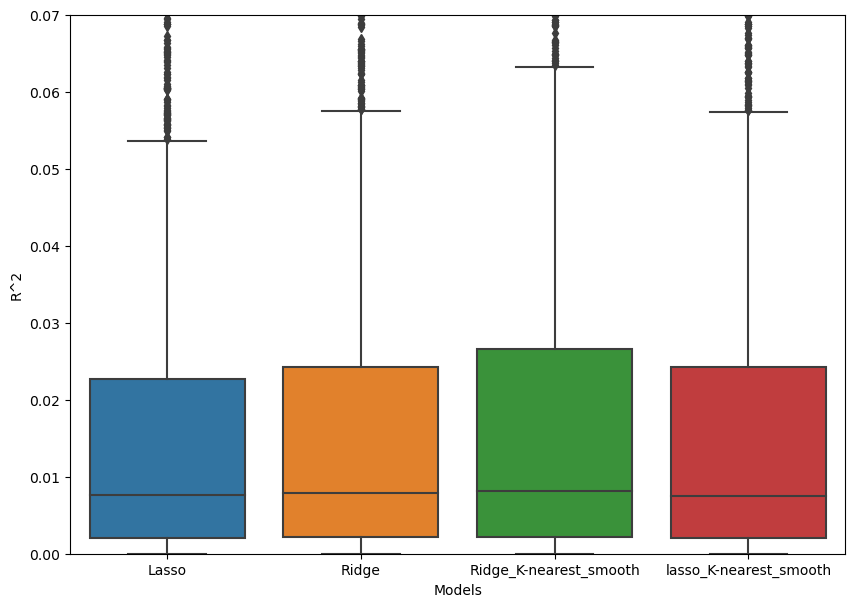

In [180]:
figures = plt.figure(figsize = (10,7))

#plot = sns.stripplot(x="Models", y='R^2', data=temp_df, size = 10, color = 'blue', alpha = 0.3)

#Hybrid_First = [mean_pluri, mean_meso, mean_cardio]
#error = [std_pluri, std_meso, std_pluri]
#plt.errorbar(range(3), Hybrid_First, yerr=error, capsize = 8, ecolor = 'grey', ls = 'none')
ax = sns.boxplot(x="Models", y="R^2", data=temp_df)

ax.set(ylim=(0,0.07))

x_pos = np.arange(len(conditions))
plt.savefig("Log Normalization")


In [99]:
# read in the unnormalize values

In [103]:
peak_unnorm = peak_unnorm.iloc[:,3:]
expression_unnorm = expression_unnorm.iloc[:,4:]

In [133]:
x_list = list(peak_unnorm.sum(0))
y_list = list(expression_unnorm.sum(0))

In [134]:
for i in range(len(x_list)):
    x_list[i] = math.log(x_list[i])
for i in range(len(y_list)):
    y_list[i] = math.log(y_list[i])

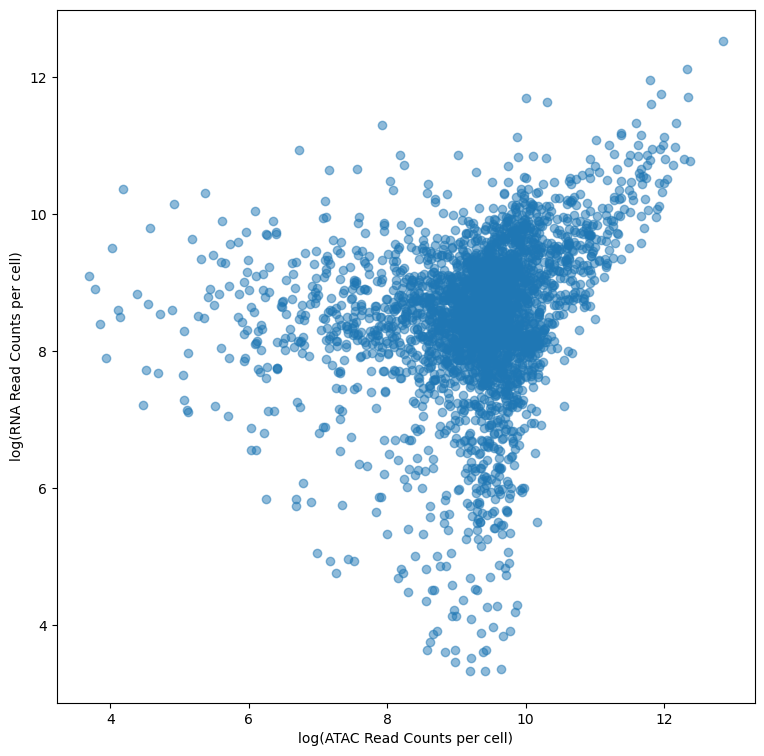

In [147]:

fig, ax = plt.subplots(figsize = (9, 9))
ax.scatter(x_list, y_list, alpha=0.5)
plt.xlabel("log(ATAC Read Counts per cell)")
plt.ylabel("log(RNA Read Counts per cell)")
plt.savefig("Scatter_of_distribution")

#b, a = np.polyfit(x_list, y_list, deg=1)
#xseq = np.linspace(3, 14, num=14)
#ax.plot(xseq, a + b * xseq, color="k", lw=2.5)

plt.show()

After this lines, the rest will be some draft

In [81]:
device = "cuda"

In [37]:
R_2

[0.00021620509504128167,
 0.02458033136177097,
 0.010276653761703912,
 0.002353880352166004,
 0.00045987722728317647,
 0.04389017418129183,
 0.028452728481905405,
 0.005178914369470583]

In [461]:
#All_beta

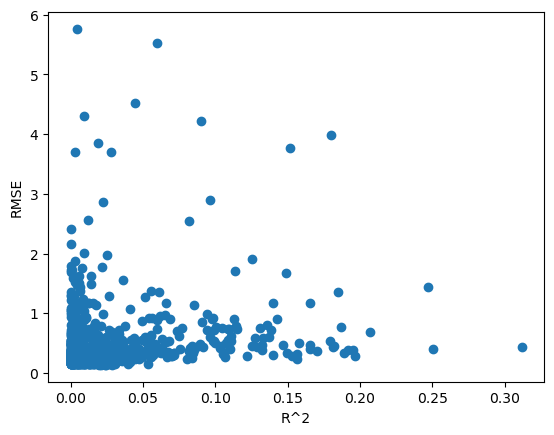

In [54]:
plt.scatter(R_2, RMSE_values)
#plt.title("R^2=%f pvalue=%f" % (R**2, p))
plt.xlabel("R^2")
plt.ylabel("RMSE")
plt.savefig("normalized_ridge")
plt.show()


In [415]:
N = len(y)
print(N)
np.random.seed(123) # for reproducibility
rand_perm = np.random.permutation(N)
train_idx = rand_perm[:int(np.ceil(0.8 * N))]
val_idx = rand_perm[int(np.ceil(0.8 * N)):int(np.ceil(0.9 * N))]
test_idx = rand_perm[int(np.ceil(0.9 * N)):]

X_train = x[train_idx,:]
X_val = x[val_idx,:]
X_test = x[test_idx,:]

y_train = y[train_idx]
y_val = y[val_idx]
y_test = y[test_idx]
print(len(y_val))

rand_perm[:10]

3233
323


array([1287,  112,  227, 1531, 2671,  690, 1039,  481, 1466, 3070])

Lambda=0.000001, fitting...
Lambda=0.000010, fitting...
Lambda=0.000100, fitting...
Lambda=0.001000, fitting...
Lambda=0.010000, fitting...
Lambda=0.100000, fitting...


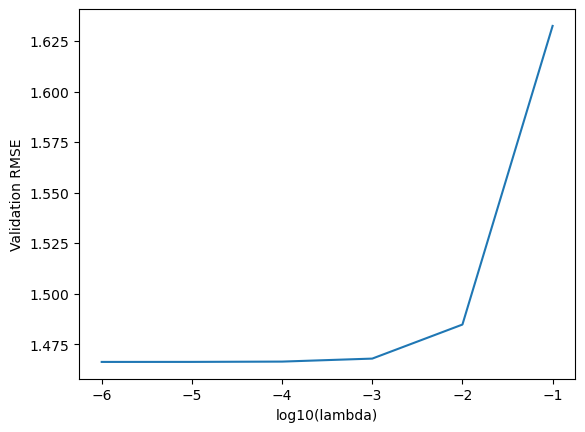

In [416]:
lambdas = 10.**torch.arange(-6,0,step=1,dtype=torch.float)
val_rmse = np.zeros(len(lambdas))
learning_rate = 0.001
for lbd_idx,lamb in enumerate(lambdas): 
    print("Lambda=%f, fitting..." % lamb) 
    beta, _ = fit_lasso(X_train, y_train, lamb, distant, learning_rate = learning_rate)
    pred_val = X_val @ beta # make predictions on the validation set
    val_rmse[lbd_idx] = np.sqrt(torch.mean((y_val - pred_val)**2).item()) # item() gets the scalar value
_ = plt.plot(np.log10(lambdas.numpy()), val_rmse)
_ = plt.xlabel("log10(lambda)")
_ = plt.ylabel("Validation RMSE")

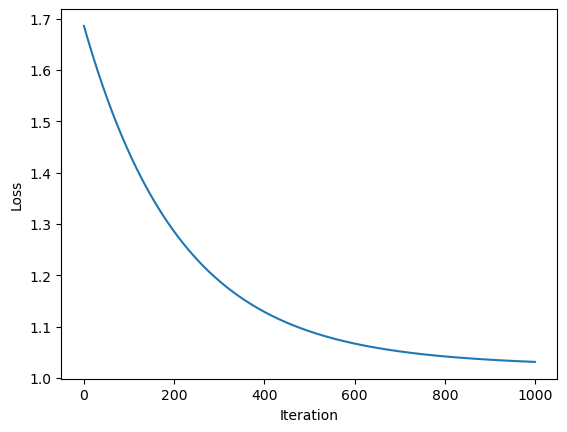

In [417]:
beta,losses = fit_lasso(X_train, y_train, distants = distant, lamb = 0.002, iterations = 1000, learning_rate = 0.0001)
_ = plt.plot(losses)
_ = plt.xlabel("Iteration")
_ = plt.ylabel("Loss")




In [419]:
x

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [2., 0., 0.,  ..., 0., 2., 4.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [3., 3., 0.,  ..., 0., 0., 0.]])

In [420]:
y

tensor([1., 0., 1.,  ..., 0., 0., 0.])

In [421]:
#distant

In [422]:
#beta

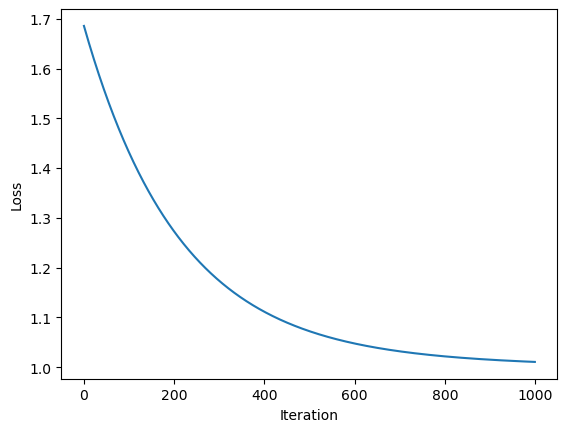

In [423]:
beta,losses = ridge_regression_gd(X_train, y_train, distants = distant, lamb = 0.002, iterations = 1000, learning_rate = 0.0001)
_ = plt.plot(losses)
_ = plt.xlabel("Iteration")
_ = plt.ylabel("Loss")




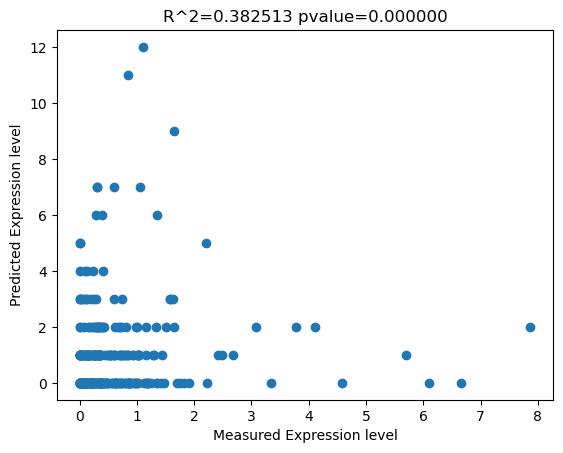

In [424]:
pred_test = X_test @ beta # make predictions on the test set
R,p = scipy.stats.pearsonr(y_test, pred_test)
plt.scatter(pred_test, y_val)
plt.title("R^2=%f pvalue=%f" % (R**2, p))
plt.xlabel("Measured Expression level")
plt.ylabel("Predicted Expression level")
plt.show()

In [182]:
interval = 5000000
N = 3233
np.random.seed(123) # for reproducibility
rand_perm = np.random.permutation(N)
train_idx = rand_perm[:int(np.ceil(0.8 * N))]
val_idx = rand_perm[int(np.ceil(0.8 * N)):int(np.ceil(0.9 * N))]
test_idx = rand_perm[int(np.ceil(0.9 * N)):]


R_2 = []
possibility = []
All_beta = []
RMSE_values = []
for index, gene in expression.iterrows():
    if 'chr' not in str(gene['chromosome']):
        continue
    current_chr = gene['chromosome']
    feature_id = gene['feature_id']
    gene = expression[expression['feature_id'] == feature_id]
    TSS = int(gene['TSS'])
    y = gene.iloc[:,4:]
    y = torch.from_numpy(y.values).float()
    y = torch.transpose(y, 0, 1)
    y = y[:,0]

    peaks = peak[(peak['chromosome'] == current_chr) & (peak['avg_position'] >= (TSS-interval)) & (peak['avg_position'] <= (TSS+interval))].copy()
    peaks['distant'] = abs(peaks['avg_position'] - TSS) + 2
    x = peaks.iloc[:,3:-1]
    x = torch.from_numpy(x.values).float()
    x = torch.transpose(x, 0, 1)
    distant = torch.from_numpy(peaks['distant'].values).float()
    distant = torch.log(distant)


    X_train = x[train_idx,:]
    X_val = x[val_idx,:]
    X_test = x[test_idx,:]

    y_train = y[train_idx]
    y_val = y[val_idx]
    y_test = y[test_idx]

    rand_perm[:10]
    
    
    beta = ridge_regression(X_train, y_train, lamb = 0.0001, distants = distant )
    if len(beta) != 0 and torch.isnan(beta)[0] != True:
        pred_test = X_test @ beta # make predictions on the test set
        R,p = scipy.stats.pearsonr(y_test, pred_test)
        R_2 += [R**2]
        possibility += [p]
        All_beta += [beta]
        MSE = mean_squared_error(y_test, pred_test)
        RMSE = math.sqrt(MSE)
        RMSE_values += [RMSE]


In [182]:
peak = pd.read_csv('normalize_peak.csv')
expression = pd.read_csv('normalize_expression_level.csv')
X_train, X_val, X_test, y_train, y_val, y_test = sample_split(expression,peak, 3233)


[pca] >Processing dataframe..
[pca] >The PCA reduction is performed on the [2587] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[5]
[pca] >Outlier detection using SPE/DmodX with n_std=[2]


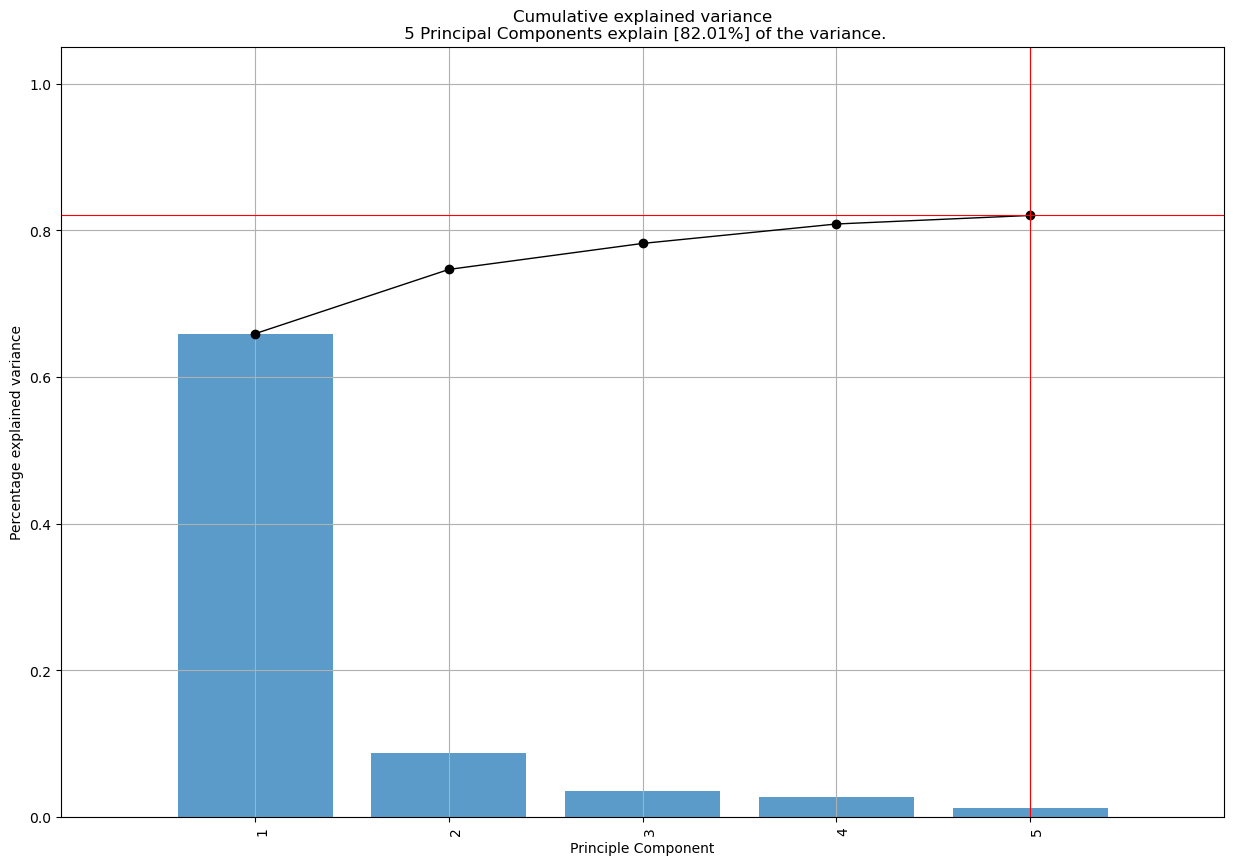

[pca] >Processing dataframe..
[pca] >The PCA reduction is performed on the [323] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[5]
[pca] >Outlier detection using SPE/DmodX with n_std=[2]


<Figure size 640x480 with 0 Axes>

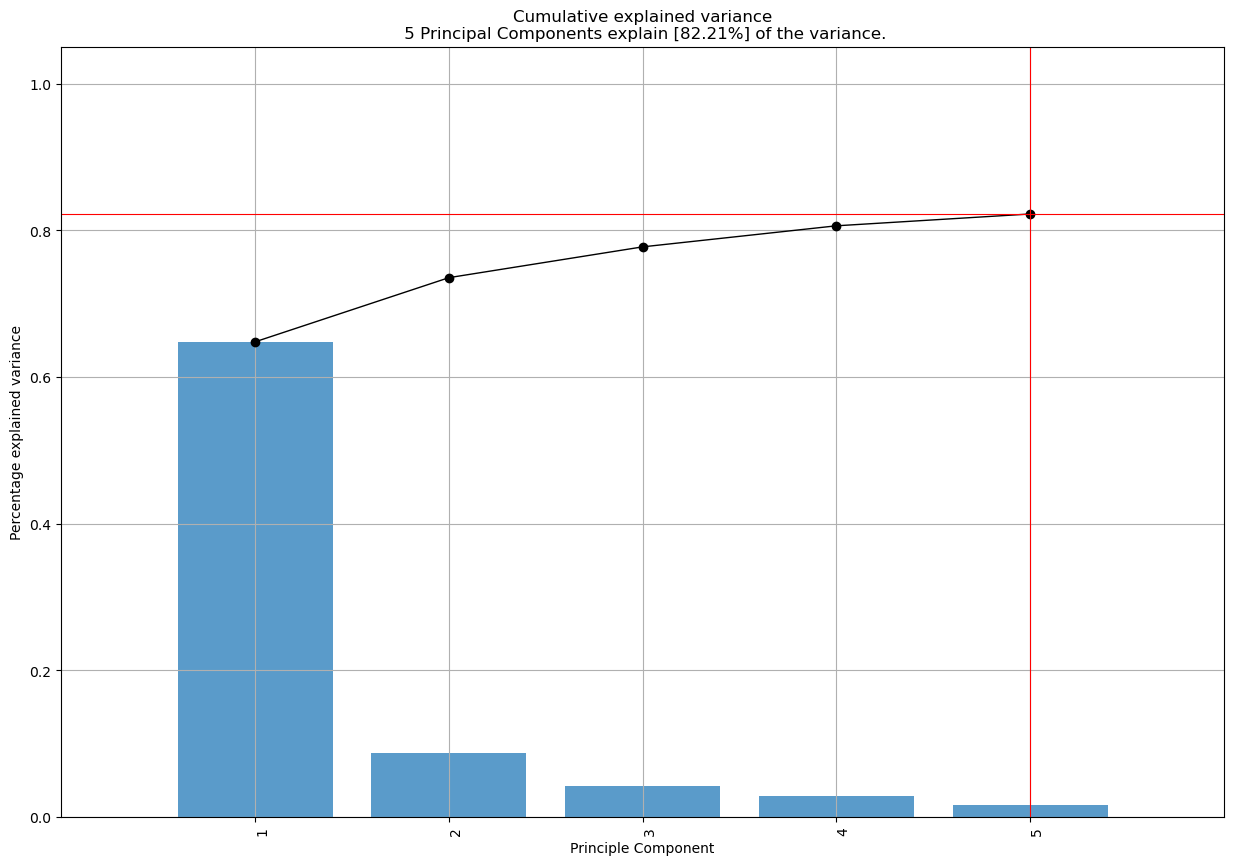

[pca] >Processing dataframe..
[pca] >The PCA reduction is performed on the [323] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[5]
[pca] >Outlier detection using SPE/DmodX with n_std=[2]


<Figure size 640x480 with 0 Axes>

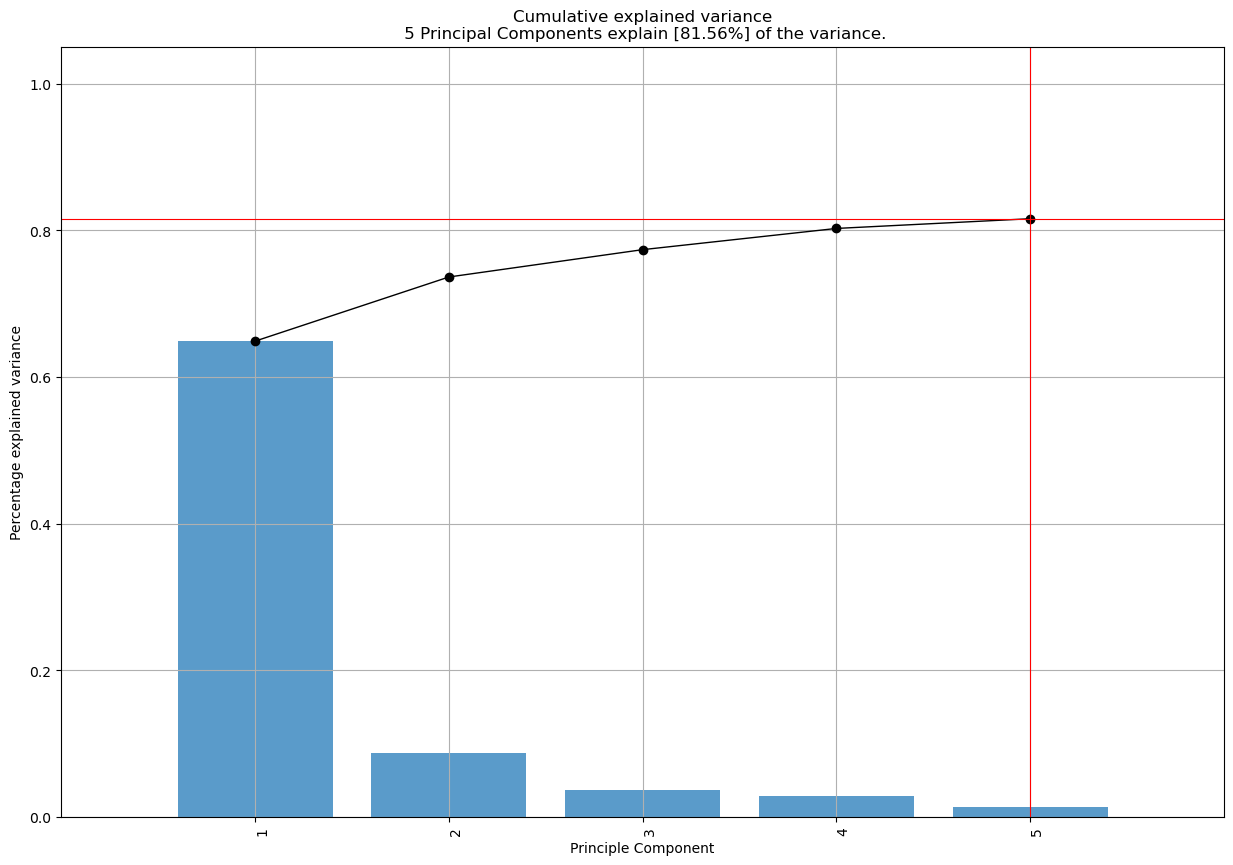

<Figure size 640x480 with 0 Axes>

In [183]:
X_train_smoothed = aggregate_smooth_function(y_train, X_train, components = 5,k= 30, fig_name = 'PCA_result.png')
X_val_smoothed = aggregate_smooth_function(y_val, X_val, components = 5,k= 30, fig_name = 'PCA_result.png')
X_test_smoothed = aggregate_smooth_function(y_test, X_test, components = 5,k= 30, fig_name = 'PCA_result.png')



In [184]:
#calculation ridge for smoothed X_train 
R_2_smooth_ridge = []
possibility_smooth_ridge = []
All_beta_smooth_ridge = []
RMSE_values_smooth_ridge = []
for index, gene in expression.iterrows():
    if 'chr' not in str(gene['chromosome']):
        continue
    current_chr = gene['chromosome']
    feature_id = gene['feature_id']
    
    X_train_i, y_train_i, distant = gene_extraction(feature_id,current_chr, y_train, X_train_smoothed,5000000)
    X_val_i, y_val_i, _  = gene_extraction(feature_id,current_chr, y_val, X_val_smoothed,5000000)
    X_test_i, y_test_i, _ = gene_extraction(feature_id,current_chr, y_test, X_test_smoothed,5000000)
    
    if len(X_train_i)== 0:
        continue
    
    beta = ridge_regression_optimaization(X_train_i, y_train_i,X_val_i, y_val_i, distants = distant, iterations = 200, learning_rate = 0.02)
    
    if beta != None and len(beta) != 0 and torch.isnan(beta)[0] != True:#eliminate some bad results
        
        pred_test = X_test_i @ beta # make predictions on the test set
        R,p = scipy.stats.pearsonr(y_test_i, pred_test)
        R_2_smooth_ridge += [R**2]
        possibility_smooth_ridge += [p]
        All_beta_smooth_ridge += [beta]
    

        MSE = mean_squared_error(y_test_i, pred_test)
        RMSE = math.sqrt(MSE)
        RMSE_values_smooth_ridge += [RMSE]

In [186]:
sum(R_2_smooth_ridge)/len(R_2_smooth_ridge)

0.07235246641303292

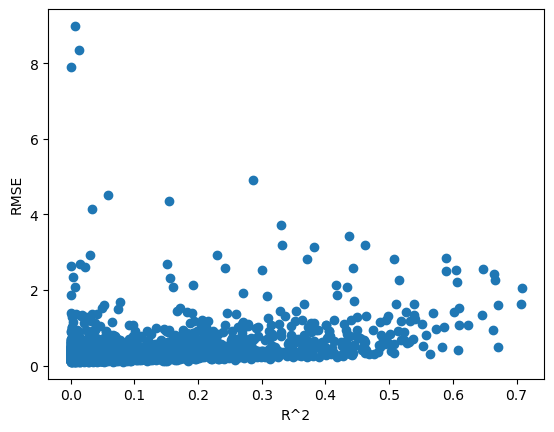

In [185]:
plt.scatter(R_2_smooth_ridge, RMSE_values_smooth_ridge)
#plt.title("R^2=%f pvalue=%f" % (R**2, p))
plt.xlabel("R^2")
plt.ylabel("RMSE")
plt.savefig("smooth_all_ridge")
plt.show()




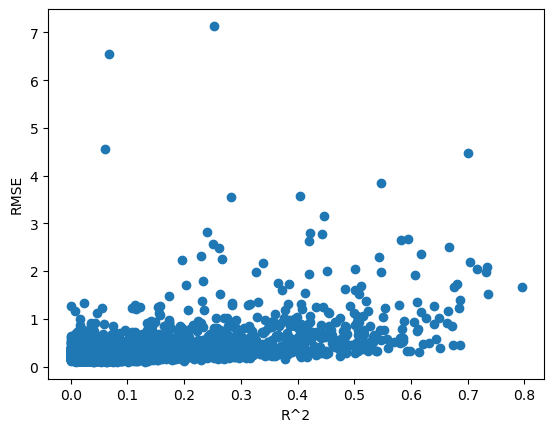

In [184]:
plt.scatter(R_2, RMSE_values)
#plt.title("R^2=%f pvalue=%f" % (R**2, p))
plt.xlabel("R^2")
plt.ylabel("RMSE")
plt.savefig("smooth_all_ridge")
plt.show()
